In [1]:
import dask.array as da
import napari
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

### Load images from zarr and compress into max projections

In [2]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

In [3]:
masks

dask.array<from-zarr, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [26]:
%%time

objects = btrack.utils.segmentation_to_objects(
    masks, 
    gfp,
    properties = ("solidity", "mean_intensity", 
)

[INFO][2022/08/01 10:53:47 AM] Localizing objects from segmentation...
[INFO][2022/08/01 10:53:47 AM] Found intensity_image data
[INFO][2022/08/01 10:53:47 AM] Calculating weighted centroids using intensity_image
[INFO][2022/08/01 11:00:16 AM] Objects are of type: <class 'dict'>
[INFO][2022/08/01 11:00:17 AM] ...Found 34804 objects in 75 frames.


CPU times: user 19min 5s, sys: 37.5 s, total: 19min 43s
Wall time: 6min 29s


Checking for no objects larger than the size exclusion criteria

In [31]:
len([o for o in objects if 2000>o.properties['area']<10.]), len([o for o in objects if 2000>o.properties['area']])

(2479, 2592)

For some unknown reason there are a lot of objects that are very very small that were not removed by the remove_small_objects function, can just remove from the objects

In [33]:
objects = [o for o in objects if o.properties['area']>100.]

# Run btrack

trying different sets of visual-features to use

In [44]:
objects[0]

{'ID': 0, 'x': 228.89509612655968, 'y': 52.45460626056397, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity': 1223.1384057971015}

In [46]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
    )
    tracker.max_search_radius = 100

    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/08/01 11:09:43 am] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 11:09:43 am] btrack (v0.5.0) library imported
[INFO][2022/08/01 11:09:43 am] Starting BayesianTracker session
[INFO][2022/08/01 11:09:43 am] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 11:09:43 am] Objects are of type: <class 'list'>
[WARNING][2022/08/01 11:09:43 am] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 11:09:43 am] Starting tracking... 
[INFO][2022/08/01 11:09:43 am] Update using: ['MOTION']
[INFO][2022/08/01 11:09:44 am] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/08/01 11:10:16 am]  - Timing (Bayesian updates: 438.93ms, Linking: 21.73ms)
[INFO][2022/08/01 11:10:16 am]  - Probabilities (Link: 0.00000, Lost: 0.00000)
[INFO][2022/08/01 11:10:16 am]  - Stats (Active: 3471, Lost: 0, Conflicts resolved: 26)
[INFO][2022/08/01 11:10:16 am] Tracking ob

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1973: obj =   3.852837334e+05 inf =   0.000e+00 (70671)
*  3817: obj =   3.639771334e+05 inf =   0.000e+00 (66499)
*  5691: obj =   3.409348834e+05 inf =   0.000e+00 (62467)
*  7548: obj =   3.178527334e+05 inf =   0.000e+00 (58508)
*  9286: obj =   2.976433834e+05 inf =   0.000e+00 (54599)
* 10876: obj =   2.835477549e+05 inf =   0.000e+00 (51213)
* 12066: obj =   2.805577812e+05 in

[INFO][2022/08/01 11:11:56 am] Writing tracks/obj_type_1
[WARNING][2022/08/01 11:11:57 am] Removing tracks/obj_type_1.
[INFO][2022/08/01 11:11:57 am] Writing LBEP/obj_type_1
[INFO][2022/08/01 11:11:57 am] Writing fates/obj_type_1
[INFO][2022/08/01 11:11:57 am] Closing HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5
[INFO][2022/08/01 11:12:00 am] Ending BayesianTracker session


# Check out the tracks

In [47]:
print('average track length:', np.mean([len(track) for track in tracks]))

average track length: 1.0


(array([    0.,     0.,     0.,     0.,     0., 32148.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

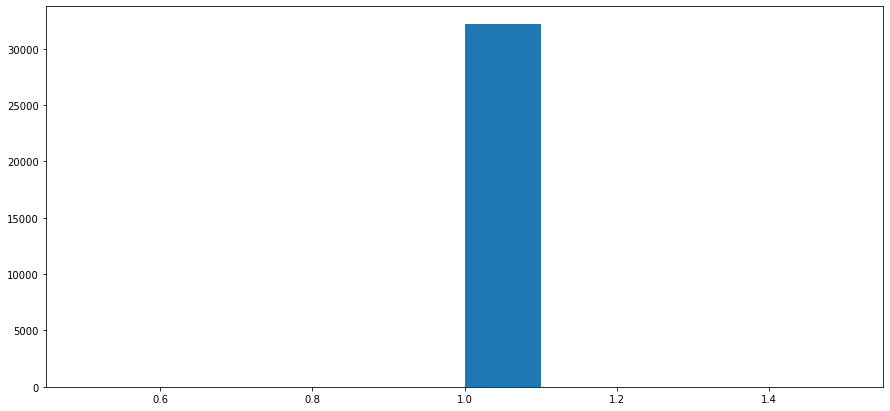

In [48]:
plt.hist([len(track) for track in tracks])

In [62]:
tracks_filt = [track for track in tracks if len(track) > 15]

In [ ]:
visaulise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [4]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
viewer.add_image(rfp, name="rfp", 
                # contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks', visible=False)
#viewer.add_tracks(visaulise_tracks, name = 'tracks IDE')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f96f8099d30>

# Conclusion from first round

These tracks perform very poorly... what if the image features are used to improve the performance?

# Trying vis feat

In [11]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
]

In [12]:
TRACKING_UPDATES = [
  "motion",
  "visual",
]

In [13]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
    )
    tracker.max_search_radius = 120
    
    tracker.features = FEATURES

    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/08/01 10:28:36 AM] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 10:28:36 AM] btrack (v0.5.0) library imported
[INFO][2022/08/01 10:28:36 AM] Starting BayesianTracker session
[INFO][2022/08/01 10:28:36 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 10:28:36 AM] Ending BayesianTracker session


NameError: name 'objects' is not defined

In [57]:
tracks_path = f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5'

In [58]:
with btrack.dataio.HDF5FileHandler(tracks_path, 
                                   'r', obj_type='obj_type_1'
                                  ) as h:
    tracks = h.tracks

[INFO][2022/07/27 03:53:46 PM] Opening HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5...
[INFO][2022/07/27 03:53:46 PM] Loading tracks/obj_type_1
[INFO][2022/07/27 03:53:46 PM] Loading objects/obj_type_1 (32222, 5) (32222 filtered: None)
[INFO][2022/07/27 03:53:47 PM] Closing HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5


# Check out the tracks

(array([1.352e+04, 2.137e+03, 3.900e+02, 8.000e+01, 3.700e+01, 1.100e+01,
        2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00]),
 array([ 1. ,  4.7,  8.4, 12.1, 15.8, 19.5, 23.2, 26.9, 30.6, 34.3, 38. ]),
 <BarContainer object of 10 artists>)

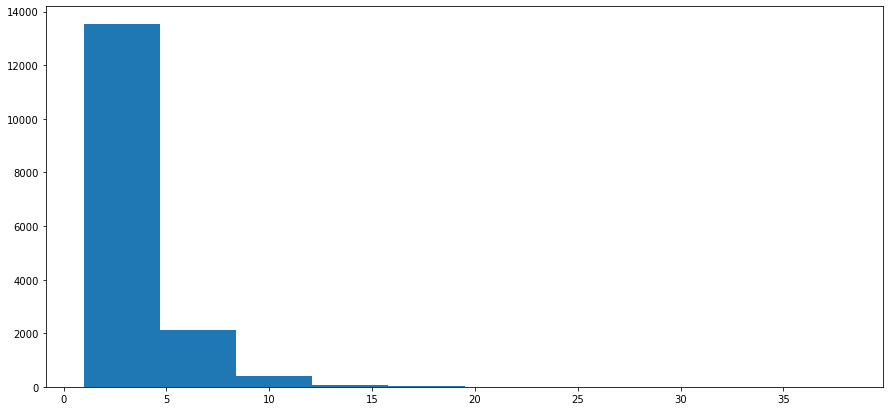

In [61]:
plt.hist([len(track) for track in tracks])

In [62]:
tracks_filt = [track for track in tracks if len(track) > 15]

In [63]:
view_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [4]:
viewer = napari.Viewer()
# viewer.add_image(gfp, name="gfp", 
#                  #contrast_limits=[0,255],
#                  blending = 'additive', colormap = 'green')
# viewer.add_image(rfp, name="rfp", 
#                 # contrast_limits=[0,55], 
#                  blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
# viewer.add_tracks(view_tracks, name = 'tracks_filtered')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f375da03970>

In [ ]:
mask